In [1]:
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import random

import torch
from torch.utils.data import DataLoader

from yolo import YOLOv2
from loss import yolo_loss 
from anchors import generate_anchors
from dataset import FruitDataset
from utils import (output_tensor_to_boxes, nonmax_suppression, 
                   x1y1wh2xyxy, target_tensor_to_boxes)

from visualizer import visualize_bbox, plot_img

In [2]:
cls_names = ['apple', 'banana', 'orange']
desired_height = desired_width = 416
grid_size = 13
size = (32, 64, 152)
aspect_ratios = (.5, 1.0, 2.0)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
anchor_boxes = generate_anchors(size, aspect_ratios)
num_anchor_boxes = len(anchor_boxes)

model = YOLOv2(S=grid_size, num_anchor_boxes=num_anchor_boxes,
               num_classes=len(cls_names))
model.to(device)

YOLOv2(
  (net): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Sequential(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
      (3): Dropout(p=0.2, inplace=False)
    )
    (3): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
      (3): Dropout(p=0.2, inplace=False)
    )
    (4): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
      (3): Dropo

In [3]:
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(4)

train_data = FruitDataset(data_file='./fruit_dataset/train', cls_names=cls_names,
                          desired_height=desired_height, desired_width=desired_width,
                          num_anchor_boxes=num_anchor_boxes)
test_data = FruitDataset(data_file='./fruit_dataset/test', cls_names=cls_names,
                         desired_height=desired_height, desired_width=desired_width,
                         num_anchor_boxes=num_anchor_boxes)

def collate_fn(batch):
    return tuple(zip(*batch))

train_loader = DataLoader(train_data, batch_size=5, shuffle=True,
                          num_workers=0, drop_last=True,
                          collate_fn=collate_fn,
                          worker_init_fn=seed_worker,
                          generator=g)
test_loader = DataLoader(test_data, batch_size=1, shuffle=True,
                          num_workers=0, drop_last=True,
                          collate_fn=collate_fn,
                          worker_init_fn=seed_worker,
                          generator=g)

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


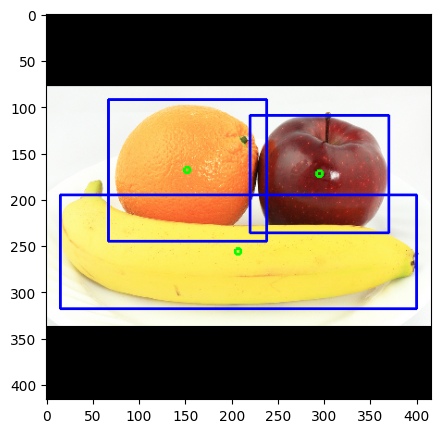

 99%|█████████▉| 198/200 [00:32<00:00,  6.15it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


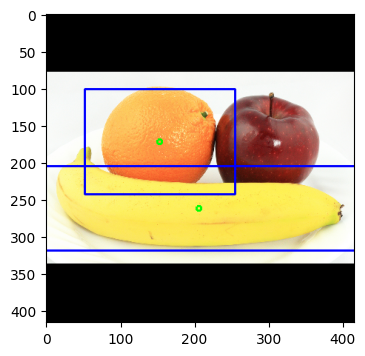

100%|██████████| 200/200 [00:32<00:00,  6.12it/s]


In [4]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
iters = 1
torch.autograd.set_detect_anomaly(True)
losses = []

ANCHOR_BOXS = [[1.08,1.19],
                [3.42,4.41],
                [6.63,11.38],
                [9.42,5.11],
                [11.,10.52]]

imgs, targets = next(iter(train_loader))
demo_img = imgs[0].permute(1,2,0).cpu().numpy()
boxes, cfs, cls = target_tensor_to_boxes(targets[0])
boxes = x1y1wh2xyxy(boxes)
#boxes = [[int(box[0]), int(box[1]), int(box[0] + box[2]), int(box[1] + box[3])] for box in boxes] if 
plot_img(visualize_bbox(demo_img.copy(), boxes=boxes), size=(5,5))

for epoch in tqdm(range(200)):
    model.zero_grad()

    #imgs, targets = next(iter(train_loader))
    tensor_imgs, tensor_targets = torch.stack(imgs), torch.stack(targets)
    output = model(tensor_imgs.to(device))
    loss = yolo_loss(pred_tensor=output, gt_tensor=tensor_targets.to(device),
                     anchor_boxes=anchor_boxes)
    #loss = custom_loss(output, tensor_targets)
    loss_value = loss.item()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    iters += 1

    losses.append(loss_value)

    if iters%200 == 0:
        ## Test nay trên tập train, nếu kết quả thỏa mãn đồng nghĩa với code của bạn đã chạy đúng 
        boxes = output_tensor_to_boxes(output[0].detach().cpu(), anchor_boxes=ANCHOR_BOXS)
        boxes = nonmax_suppression(boxes)
        boxes = [[int(box[0]), int(box[1]), int(box[0] + box[2]), int(box[1] + box[3])] for box in boxes]
        img = imgs[0].permute(1,2,0).cpu().numpy() 
        img = visualize_bbox(img.copy(), boxes=boxes)
        plot_img(img, size=(4,4))

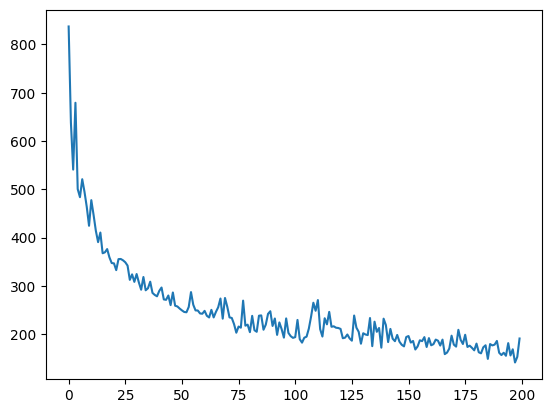

In [5]:
plt.plot(losses)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


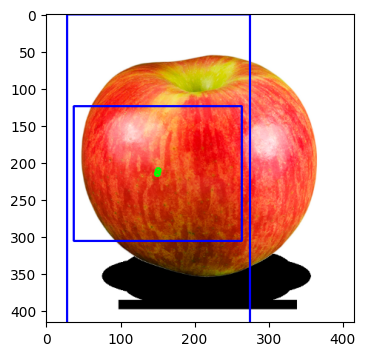

In [6]:
imgs, targets = next(iter(test_loader))
tensor_imgs, tensor_targets = torch.stack(imgs), torch.stack(targets)
output = model(tensor_imgs.to(device))

boxes = output_tensor_to_boxes(output[0].detach().cpu(),
                                grid_size=grid_size, img_w=desired_width,
                                img_h=desired_height, num_anchor_boxes=num_anchor_boxes,
                                anchor_boxes=anchor_boxes, output_thres=0.7)
boxes = nonmax_suppression(boxes)
img = imgs[0].permute(1,2,0).cpu().numpy()
boxes = [[max(box[0], 0), max(box[1], 0), box[0] + box[2], box[1] + box[3]] for box in boxes]
img = visualize_bbox(img.copy(), boxes=boxes)
plot_img(img, size=(4,4))